# Reproduce deep neural network from Tesseract

---

First, let's get the Drebin feature dataset, since Tesseract used the deep
learning algorithm with Drebin features.

In [1]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

### Visualise the temporal distribution of the dataset

(This is the exact same as for Drebin and MaMaDroid)

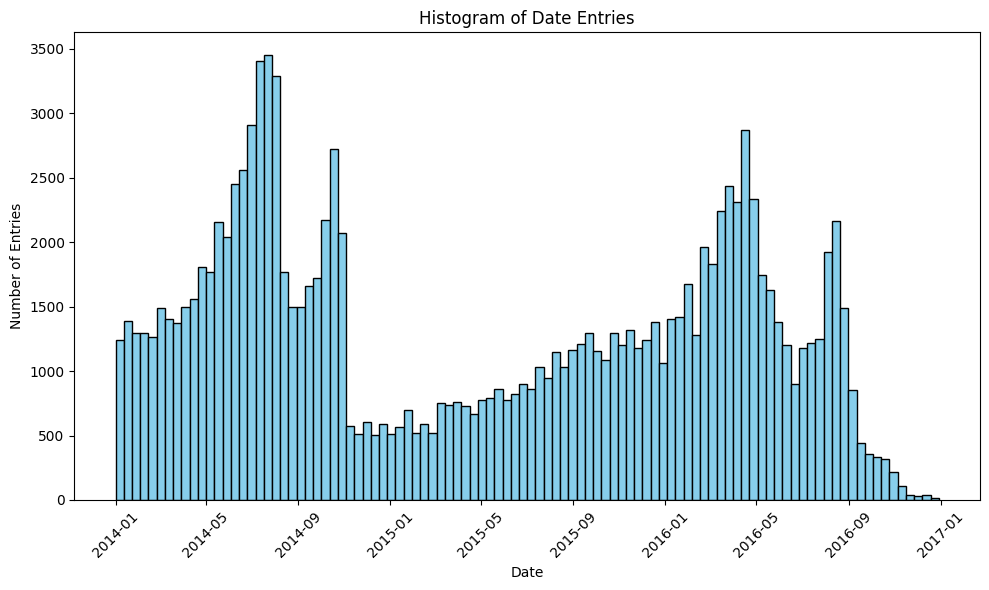

In [2]:
plt.figure(figsize=(10, 6))
plt.hist(t, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
print(f"The earliest timestamp in the dataset is {t.min()}")
print(f"The latest timestamp in the dataset is {t.max()}")

The earliest timestamp in the dataset is 2014-01-01 00:25:40
The latest timestamp in the dataset is 2016-12-29 15:17:46


### Partition the dataset 

More details on this can be found in `tesseract-reproduce-drebin.ipynb`. 

In [ ]:
from tesseract import evaluation, temporal, metrics

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [5]:
X_train, X_test, y_train, y_test, _, _ = splits

Tesseract specifies that they have used the deep neural network from the paper
called *Adversarial Examples for Malware Detection* that can be found
[here](https://link.springer.com/chapter/10.1007/978-3-319-66399-9_4). 
This paper states that their deep neural network's architecture has 2 hidden
layers with each 200 neurons. We replicate this here using a Keras model. 

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Input(shape=(1140816,)), 
    Dense(200, activation='relu'), 
    Dense(200, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

We also need to create a custom train and predict function, so that the
Tesseract `fit_predict_update()` function can work with the Keras model.

In [13]:
# Train the model
def dl_fit_function(X_train, y_train):
    return model.fit(
        X_train, 
        y_train, 
        epochs=1, 
        batch_size=265, 
    )

def dl_predict_function(X_test):
    probabilities = model.predict(X_test, verbose=0)
    return (probabilities > 0.5).astype(int).flatten()

In [14]:
results = evaluation.fit_predict_update(
    model, 
    *splits, 
    fit_function=dl_fit_function, 
    predict_function=dl_predict_function
)

2024-11-30 17:11:50.939721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [57740]
	 [[{{node Placeholder/_1}}]]
2024-11-30 17:11:50.941772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [57740]
	 [[{{node Placeholder/_1}}]]


218/218 [==============================] - 2452s 11s/step - loss: 0.0933 - accuracy: 0.9708


2024-11-30 17:53:13.218813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [1708,3]
	 [[{{node Placeholder/_0}}]]
2024-11-30 17:53:13.647293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [1360,3]
	 [[{{node Placeholder/_0}}]]
2024-11-30 17:53:14.049988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shap

In [15]:
# View results 
metrics.print_metrics(results)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results, 'f1'))

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

### Plotting the results

F1 AUT: 0.5749260126830252
Recall AUT: 0.47231427405337056
Precision AUT: 0.8247112954803381


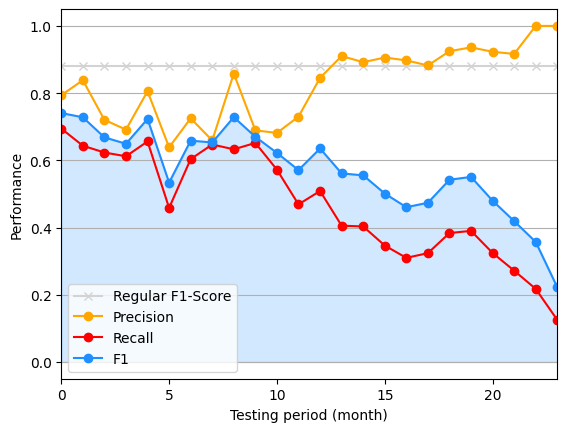

In [18]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")

from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

# Add the F1-Score when doing regular splitting to the plot
regular_f1_score = [0.88] * 24

plot(regular_f1_score, marker='x', color='lightgray')
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
fill_between(np.arange(0, 24), results['f1'], alpha=0.2, color=pendleblue)
legend(['Regular F1-Score', 'Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')